## Import Data


In [30]:
# Clean & runnable version of your pipeline (DBSCAN + metrics + AQI)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from scipy import stats

In [31]:
# === 1. Load & Cleaning ===
data = pd.read_csv("DukuhKupang.csv")
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)']
data = data.drop(columns=drop_cols).dropna().drop_duplicates()

In [32]:
print(data.isna().sum())
print(data.isnull().sum())
print(data.duplicated().sum())

PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
0


In [33]:
data = data.dropna()
data = data.drop_duplicates()
data.duplicated().sum()

0

In [34]:
# optional: remove outliers using z-score (based on numeric columns)
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(data[numeric_cols]))
mask = (z_scores < 3).all(axis=1)
df_clean = data.loc[mask].reset_index(drop=True)

print("Final shape setelah cleaning:", df_clean.shape)

Final shape setelah cleaning: (37486, 6)


In [35]:
print("Final shape setelah cleaning:", df_clean.shape)

Final shape setelah cleaning: (37486, 6)


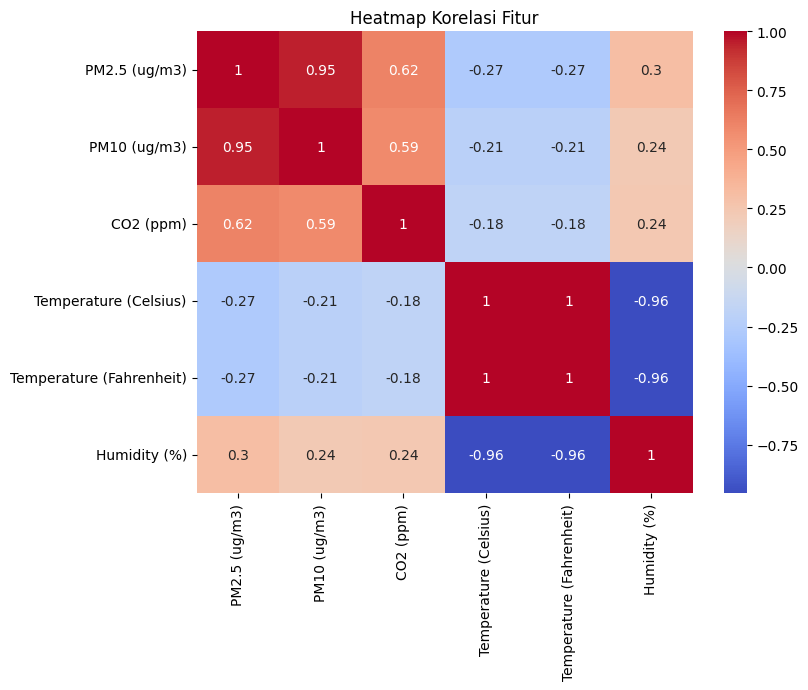

In [36]:
# --- 4. Visualisasi Korelasi ---
plt.figure(figsize=(8,6))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

# Prepocessing

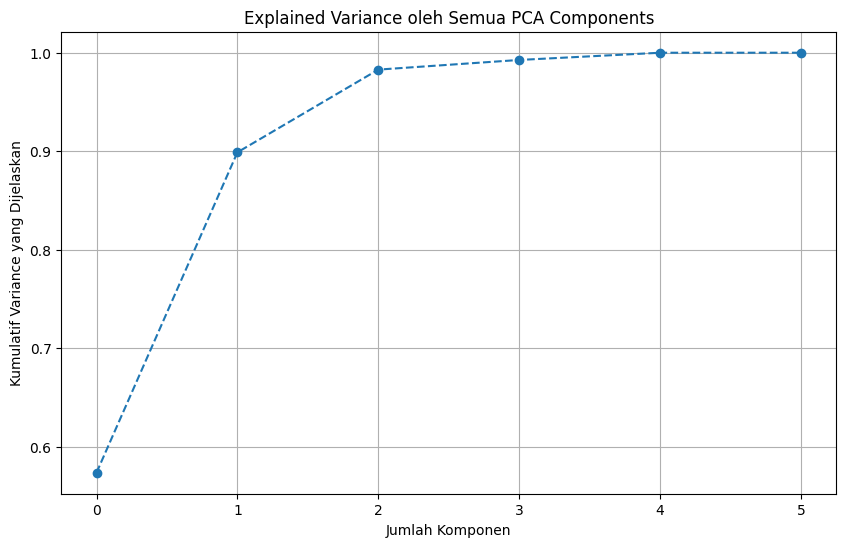

Explained variance ratio (3 components): [0.5738042  0.32512566 0.08393476]
Total explained variance (3 comp): 0.9828646182879363


In [37]:
# -------------------------
# 2) Scaling + PCA
# -------------------------
scaler = StandardScaler()
X = df_clean[numeric_cols].values  # matrix of features to cluster
X_scaled = scaler.fit_transform(X)

# PCA: compute full explained variance then keep 3 components (as you had)
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Explained Variance oleh Semua PCA Components')
plt.grid(True)
plt.show()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (3 components):", pca.explained_variance_ratio_)
print("Total explained variance (3 comp):", pca.explained_variance_ratio_.sum())


In [38]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio (2 components): [0.5738042  0.32512566 0.08393476]
Total explained variance: 0.9828646182879363


# Clustering

In [40]:
# -------------------------
# 3) DBSCAN grid search (tqdm)
# -------------------------
eps_values = np.arange(0.2, 2.0, 0.2)
min_samples_values = range(3, 10)

best_config = None
best_score = -1.0  # silhouette (higher better)

print("===== DBSCAN GRID SEARCH =====")
total_iter = len(eps_values) * len(min_samples_values)
with tqdm(total=total_iter, desc="DBSCAN Progress") as pbar:
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbs = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbs.fit_predict(X_pca)

            unique = set(labels)
            # require at least 2 non-noise clusters
            n_non_noise_clusters = len([u for u in unique if u != -1])
            if n_non_noise_clusters < 2:
                pbar.update(1)
                continue

            # silhouette: compute on non-noise points
            try:
                mask_non_noise = labels != -1
                sil = silhouette_score(X_pca[mask_non_noise], labels[mask_non_noise])
                dbi = davies_bouldin_score(X_pca[mask_non_noise], labels[mask_non_noise])
            except Exception as e:
                # skip unstable configs (e.g., singletons)
                pbar.update(1)
                continue

            print(f"eps={eps:.1f}, min_samples={min_samples} => Sil={sil:.3f}, DBI={dbi:.3f}")

            if sil > best_score:
                best_score = sil
                best_config = (eps, min_samples, sil, dbi)
            pbar.update(1)

if best_config is None:
    raise RuntimeError("Tidak menemukan konfigurasi DBSCAN yang valid (>=2 non-noise clusters).")

print("\n🔥 Best DBSCAN Config:")
print(f"eps={best_config[0]}, min_samples={best_config[1]}, Silhouette={best_config[2]:.3f}, DBI={best_config[3]:.3f}")


===== DBSCAN GRID SEARCH =====


DBSCAN Progress:   2%|▏         | 1/63 [00:10<10:33, 10.22s/it]

eps=0.2, min_samples=3 => Sil=-0.540, DBI=0.781


DBSCAN Progress:   3%|▎         | 2/63 [00:20<10:28, 10.31s/it]

eps=0.2, min_samples=4 => Sil=-0.448, DBI=0.775


DBSCAN Progress:   5%|▍         | 3/63 [00:30<10:08, 10.14s/it]

eps=0.2, min_samples=5 => Sil=-0.440, DBI=0.783


DBSCAN Progress:   6%|▋         | 4/63 [00:40<09:50, 10.01s/it]

eps=0.2, min_samples=6 => Sil=-0.419, DBI=0.762


DBSCAN Progress:   8%|▊         | 5/63 [00:49<09:24,  9.73s/it]

eps=0.2, min_samples=7 => Sil=-0.447, DBI=0.765


DBSCAN Progress:  10%|▉         | 6/63 [00:58<09:00,  9.48s/it]

eps=0.2, min_samples=8 => Sil=-0.397, DBI=0.744


DBSCAN Progress:  11%|█         | 7/63 [01:07<08:37,  9.25s/it]

eps=0.2, min_samples=9 => Sil=-0.268, DBI=0.792


DBSCAN Progress:  13%|█▎        | 8/63 [01:18<09:09,  9.99s/it]

eps=0.4, min_samples=3 => Sil=-0.072, DBI=0.709


DBSCAN Progress:  14%|█▍        | 9/63 [01:30<09:19, 10.36s/it]

eps=0.4, min_samples=4 => Sil=0.034, DBI=0.640


DBSCAN Progress:  16%|█▌        | 10/63 [01:41<09:24, 10.65s/it]

eps=0.4, min_samples=5 => Sil=0.122, DBI=0.909


DBSCAN Progress:  17%|█▋        | 11/63 [01:52<09:25, 10.88s/it]

eps=0.4, min_samples=6 => Sil=0.419, DBI=0.457


DBSCAN Progress:  22%|██▏       | 14/63 [02:05<05:57,  7.29s/it]

eps=0.4, min_samples=9 => Sil=0.474, DBI=0.397


DBSCAN Progress:  24%|██▍       | 15/63 [02:16<06:50,  8.55s/it]

eps=0.6, min_samples=3 => Sil=0.258, DBI=0.565


DBSCAN Progress:  25%|██▌       | 16/63 [02:28<07:21,  9.40s/it]

eps=0.6, min_samples=4 => Sil=0.311, DBI=0.653


DBSCAN Progress:  27%|██▋       | 17/63 [02:40<07:48, 10.18s/it]

eps=0.6, min_samples=5 => Sil=0.294, DBI=0.612


DBSCAN Progress: 100%|██████████| 63/63 [05:00<00:00,  4.78s/it]


🔥 Best DBSCAN Config:
eps=0.4, min_samples=9, Silhouette=0.474, DBI=0.397


In [43]:
# -------------------------
# 4) Run final DBSCAN with best config
# -------------------------
dbscan_final = DBSCAN(eps=best_config[0], min_samples=best_config[1])
labels_dbscan = dbscan_final.fit_predict(X_pca)

# attach cluster labels to the original cleaned dataframe (use original feature values)
df_results = df_clean.copy().reset_index(drop=True)
df_results['Cluster'] = labels_dbscan  # -1 is noise

n_clusters = len([c for c in set(labels_dbscan) if c != -1])
n_noise = int((labels_dbscan == -1).sum())
print(f"✅ Number of clusters (non-noise): {n_clusters}")
print(f"⚠️ Noise points: {n_noise}")


✅ Number of clusters (non-noise): 2
⚠️ Noise points: 289


In [44]:
# -------------------------
# 5) Evaluation: Silhouette, DBI, CH
# -------------------------
def safe_metrics(X_for_metrics, labels):
    metrics = {'silhouette': np.nan, 'dbi': np.nan, 'calinski_harabasz': np.nan}
    unique_non_noise = [u for u in set(labels) if u != -1]
    if len(unique_non_noise) < 2:
        metrics['note'] = "Not enough non-noise clusters for metrics."
        return metrics

    # silhouette on non-noise points
    mask_non_noise = labels != -1
    try:
        metrics['silhouette'] = silhouette_score(X_for_metrics[mask_non_noise], labels[mask_non_noise])
    except Exception as e:
        metrics['note_sil'] = str(e)

    # DBI and CH on non-noise points (avoid counting noise as a cluster)
    try:
        metrics['dbi'] = davies_bouldin_score(X_for_metrics[mask_non_noise], labels[mask_non_noise])
    except Exception as e:
        metrics['note_dbi'] = str(e)
    try:
        metrics['calinski_harabasz'] = calinski_harabasz_score(X_for_metrics[mask_non_noise], labels[mask_non_noise])
    except Exception as e:
        metrics['note_ch'] = str(e)

    return metrics

metrics_dbscan = safe_metrics(X_pca, labels_dbscan)
print("\n📈 DBSCAN Metrics (computed on PCA-space (3 dim), excluding noise for metrics):")
for k,v in metrics_dbscan.items():
    print(f"{k}: {v}")


📈 DBSCAN Metrics (computed on PCA-space (3 dim), excluding noise for metrics):
silhouette: 0.474063900496566
dbi: 0.39702147642704455
calinski_harabasz: 68.08401786515113



📊 Cluster Profile (mean values of original features):


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
Cluster,,,,,,
0,36.304260,69.353762,428.738477,28.734188,83.721866,79.602028
1,132.427273,264.000000,450.272727,25.000000,77.036364,95.909091


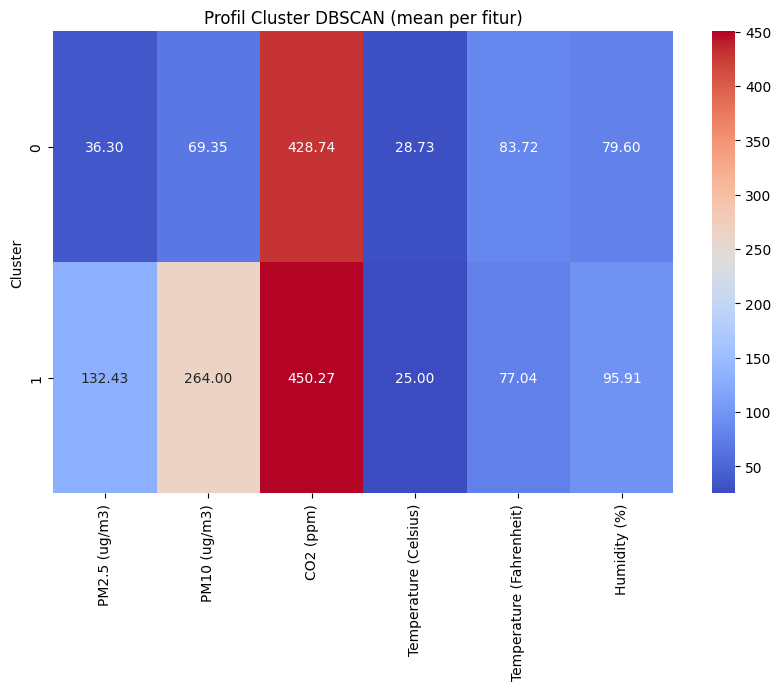

In [45]:
# -------------------------
# 6) Cluster profile (use original feature scale)
# -------------------------
cluster_profile = df_results[df_results['Cluster'] != -1].groupby('Cluster')[numeric_cols].mean()
print("\n📊 Cluster Profile (mean values of original features):")
display(cluster_profile)

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Profil Cluster DBSCAN (mean per fitur)")
plt.show()

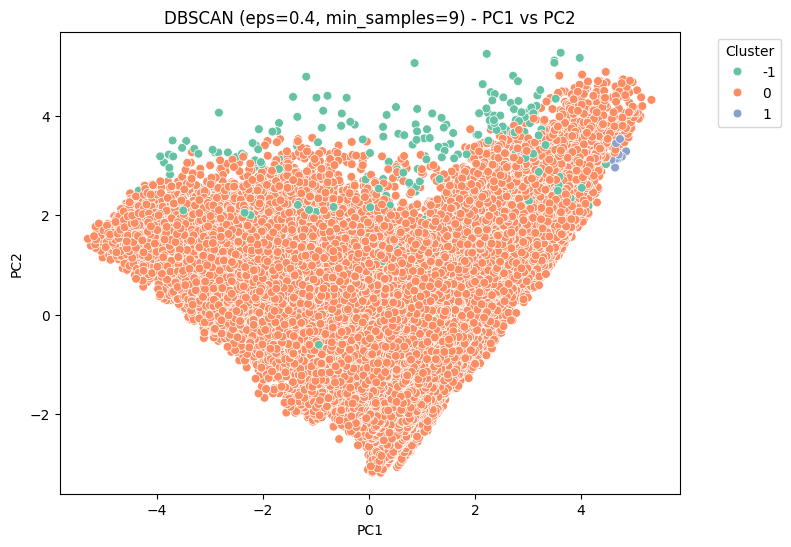

In [46]:
# -------------------------
# 7) Visualize (PCA 2D scatter)
# -------------------------
plt.figure(figsize=(8,6))
palette = sns.color_palette("Set2", n_colors=len(set(labels_dbscan)))
# use first two components for plot
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_dbscan, palette=palette, s=40, legend="full")
plt.title(f"DBSCAN (eps={best_config[0]}, min_samples={best_config[1]}) - PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

AQI_Category   Good  Severe
Cluster                    
-1               19       7
 0            14141   23312
 1                7       0


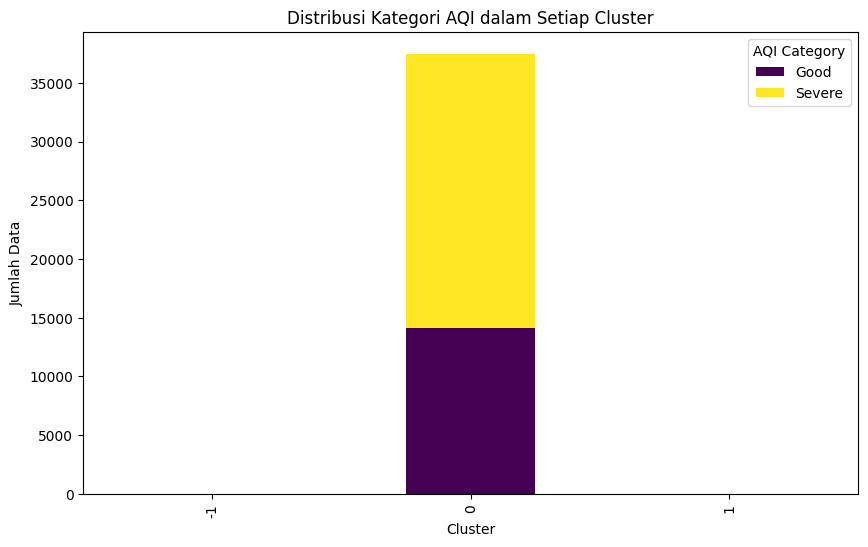

In [47]:
# --- 9. Hitung AQI (Linear Segmentation) ---

# Tabel breakpoints (Bmin, Bmax, Imin, Imax)
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)]
    
    # Contoh adaptasi CO2 (ppm)
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin) / (Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan

def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    return max(sub_pm25, sub_pm10)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

# Tambahkan ke dataframe
X_train["AQI_Value"] = X_train.apply(calculate_aqi_linear, axis=1)
X_train["AQI_Category"] = X_train["AQI_Value"].apply(categorize_aqi)

# %%
# --- 10. Crosstab Cluster vs AQI Category ---
crosstab = pd.crosstab(X_train["Cluster"], X_train["AQI_Category"])
print(crosstab)

crosstab.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()